In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

import pickle
from datetime import datetime

In [1149]:
# Import the dataset containing all the electronic music genres
df = pd.read_csv('../../data/clean_data/electronic_dataset.csv')


In [1150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           5826 non-null   object 
 1   playlist_url       5826 non-null   object 
 2   playlist_name      5826 non-null   object 
 3   track_name         5826 non-null   object 
 4   track_popularity   5826 non-null   int64  
 5   artist_name        5826 non-null   object 
 6   album              5826 non-null   object 
 7   album_cover        5826 non-null   object 
 8   artist_genres      5826 non-null   object 
 9   artist_popularity  5826 non-null   int64  
 10  danceability       5825 non-null   float64
 11  energy             5825 non-null   float64
 12  key                5825 non-null   float64
 13  loudness           5825 non-null   float64
 14  mode               5825 non-null   float64
 15  speechiness        5825 non-null   float64
 16  acousticness       5825 

In [1151]:
# Since we just have one row with missing values, we have decided to drop it
df.dropna(inplace=True)

In [1152]:
df.head()

,track_id,playlist_url,playlist_name,track_name,track_popularity,artist_name,album,album_cover,artist_genres,artist_popularity,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,3FnaCm5NYQh8prhCfPDNOV,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Promised,42,Pig&Dan,Promised,https://i.scdn.co/image/ab67616d0000b273510295...,"['dark techno', 'microhouse', 'minimal techno'...",41,...,1.0,0.0400,0.026700,0.87800,0.0854,0.0367,124.005,562229.0,4.0,techhouse
1,3oJaIce9FdZyKlpQ22jxp5,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Dark Matter,47,Dubfire,Dark Matter / Dust & Gas,https://i.scdn.co/image/ab67616d0000b273d6c80d...,"['deep minimal techno', 'minimal techno', 'tec...",43,...,1.0,0.0767,0.000703,0.88600,0.0721,0.1240,131.999,530496.0,4.0,techhouse
2,50MkrUXSXsS1Q1bn95XQcm,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Sleepless - Stephan Bodzin Remix,48,Pan-Pot,The Other Remixes,https://i.scdn.co/image/ab67616d0000b27379a15e...,"['german techno', 'microhouse', 'minimal techn...",40,...,1.0,0.0462,0.000220,0.81100,0.0869,0.0845,119.991,540000.0,4.0,techhouse
3,2hJRfyYiJ8umxp1WdbeyLj,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Dubmission - 2021 Edit,51,Anja Schneider,Dubmission (Original Edit),https://i.scdn.co/image/ab67616d0000b2730b9874...,"['electra', 'german house', 'german techno', '...",44,...,1.0,0.0947,0.335000,0.89100,0.0971,0.2760,122.033,186885.0,4.0,techhouse
4,1BpG59DLyW6jZxN2PYiUA3,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,2daBeat,47,Super Flu,Musik 3,https://i.scdn.co/image/ab67616d0000b273f2fcdb...,"['deep euro house', 'german house', 'microhous...",43,...,0.0,0.0687,0.109000,0.00864,0.0836,0.2210,120.022,329787.0,4.0,techhouse


In [1153]:
# We drop the unnecessary columns for this project
df.drop(['album_cover', 'track_id', 'playlist_url', 'playlist_name'], axis=1, inplace=True)

In [1154]:
# # Some of the and albums of the tracks have extra information added after a '-' or in between '()'
df['album'] = df['album'].str.split('(').str[0]
df['album'] = df['album'].str.split('-').str[0]

In [1155]:
# Since every electronic music genre has a specific tempo ratio, we have created a function to remove the
# Rows which have tempo outside of that threshold

def filter_tempo(data, genre, max_val, min_val):
    tempo = df.loc[df.genre == genre, 'tempo']
    
    above_threshold = tempo[tempo > max_val].index.tolist()
    below_threshold = tempo[tempo < min_val].index.tolist()
    indexNames = above_threshold + below_threshold
    
    data.drop(indexNames, inplace=True)

In [1156]:
filter_tempo(df, 'ambient', 100, 0)
filter_tempo(df, 'synthwave', 140, 80)
filter_tempo(df, 'psytrance', 170, 120)
filter_tempo(df, 'techno', 150, 120)
filter_tempo(df, 'trance', 155, 125)
filter_tempo(df, 'dnb', 185, 160)
filter_tempo(df, 'hardstyle', 165, 140)
filter_tempo(df, 'techhouse', 128, 120)
filter_tempo(df, 'trap', 165, 135)

In [1157]:
# We have lost some data but we have gained in accuracty 
df['genre'].value_counts()

techhouse    1007
techno        657
psytrance     580
trance        502
hardstyle     426
synthwave     395
ambient       385
dnb           338
trap          287
Name: genre, dtype: int64

In [1158]:
# We need to encode the categorical variables, we have used manual encoding for the genres so we can control the result

df["artist_encoded"] = le.fit_transform(df["artist_name"])
df["album_encoded"] = le.fit_transform(df["album"])

genre_encoded_dict = {'ambient' : 1,
                      'psytrance' : 2,
                      'dnb' : 3,
                      'hardstyle' : 4,
                      'trance' : 5,
                      'techno' : 6,
                      'techhouse' : 7,
                      'trap' : 8,
                      'synthwave' : 9}

df.genre = df.genre.map(genre_encoded_dict)

<AxesSubplot:xlabel='artist_popularity'>

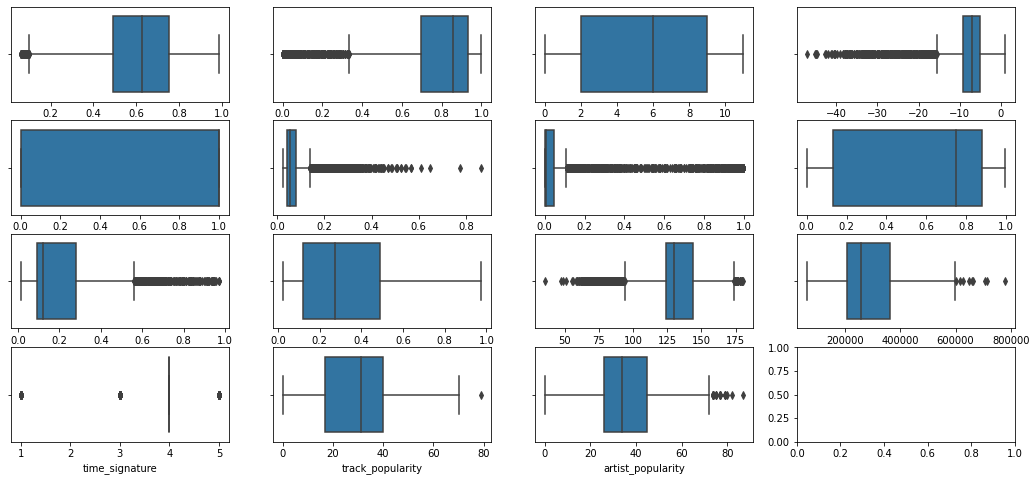

In [1116]:
# Using boxplots, we have observed the presence of outliers in our data. We have tried  to remove them with 
# windsorizing, but it hasn't affected the correlation of the features

fig, axes = plt.subplots(4, 4, figsize=(18, 8))
 
sns.boxplot(ax=axes[0, 0], x = df['danceability'])
sns.boxplot(ax=axes[0, 1], x = df['energy'])
sns.boxplot(ax=axes[0, 2], x = df['key'])
sns.boxplot(ax=axes[0, 3], x = df['loudness'])
sns.boxplot(ax=axes[1, 0], x = df['mode'])
sns.boxplot(ax=axes[1, 1], x = df['speechiness'])
sns.boxplot(ax=axes[1, 2], x = df['acousticness'])
sns.boxplot(ax=axes[1, 3], x = df['instrumentalness'])
sns.boxplot(ax=axes[2, 0], x = df['liveness'])
sns.boxplot(ax=axes[2, 1], x = df['valence'])
sns.boxplot(ax=axes[2, 2], x = df['tempo'])
sns.boxplot(ax=axes[2, 3], x = df['duration_ms'])
sns.boxplot(ax=axes[3, 0], x = df['time_signature'])
sns.boxplot(ax=axes[3, 1], x = df['track_popularity'])
sns.boxplot(ax=axes[3, 2], x = df['artist_popularity'])

<AxesSubplot:>

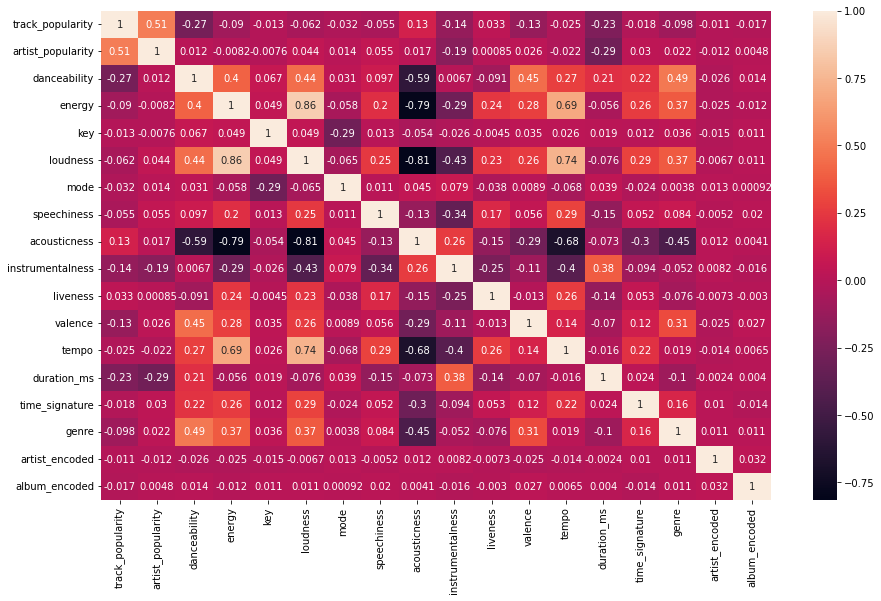

In [1160]:
plt.figure(figsize =(15, 9))
sns.heatmap(df.corr(), annot=True)

In [1118]:
# In order to have a equal distribution of our variables, we have applied logaritmic transformation

df['artist_popularity'] = np.log1p(df.artist_popularity)
df['track_popularity'] = np.log1p(df.track_popularity)
df['key'] = np.log1p(df.key)
df['tempo'] = np.log1p(df.tempo)
df['duration_ms'] = np.log1p(df.duration_ms)
df['time_signature'] = np.log1p(df.time_signature)
df['artist_encoded'] = np.log1p(df.artist_encoded)
df['album_encoded'] = np.log1p(df.album_encoded)

In [1133]:
# Once our data has been cleaned, we will start testing different models and adjusts
# First we divide our data, we will drop some columns, like the album or the artist (encoded). 
# We have also dropped some numerical features like the time signature, the key and the mode.

X = df[['track_popularity', 'artist_popularity', 'danceability', 'energy', 'loudness', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=123)

In [1134]:
# We have also applied a Min Max Scaler transformation over our features variable, in order to normalize our data

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [1122]:
# We have tested Random Forest Classifier model with different params, and these are the ones that gave the best results
# We have also tested our accuracy, recall and score

rf = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)

y_pred = rf.predict(X_test)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("RECALL OF THE MODEL: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("SCORE IN TEST: ", rf.score(X_test, y_test))
print("SCORE IN TRAIN: ", rf.score(X_train, y_train))

ACCURACY OF THE MODEL:  0.8930131004366813
RECALL OF THE MODEL:  0.9005863199486238
SCORE IN TEST:  0.8930131004366813
SCORE IN TRAIN:  0.9934444140945097


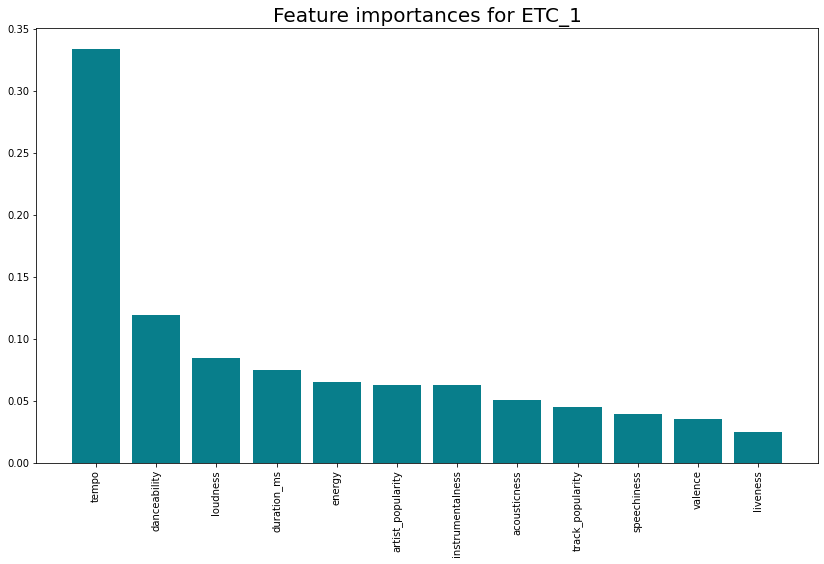

In [1123]:
# In order to observe which have been the most important features, we visualize the feature importance with a plot

importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': rf.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (14,8))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances for ETC_1', size=20)
plt.xticks(rotation='vertical')
plt.show()

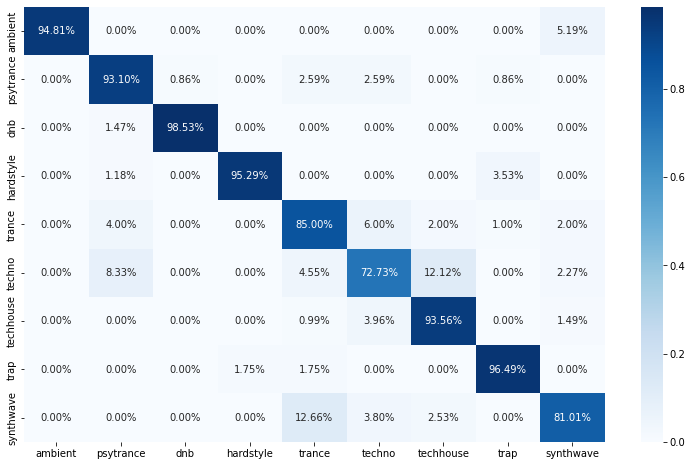

In [1124]:
# From the confusion matrix we can observe that the classes which got the worst classification, have been 
# trance, techno and synthwave

x_axis_labes = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
y_axis_labels = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
plt.figure(figsize=(13,8))
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true', labels=np.unique(y_test)), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=x_axis_labes, yticklabels=y_axis_labels);

In [1126]:
# In order to try to improve our resaults, we have tested SMOTE, a random oversampler

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_smote).items()))

X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size = 0.20)

[(1, 805), (2, 805), (3, 805), (4, 805), (5, 805), (6, 805), (7, 805), (8, 805), (9, 805)]


In [1127]:
# After testing with the model, our accuracy has improved a lot, but it can be also due to overfitting

rf = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf.fit(X_train, y_train)
# Probabilities of each genre 
rf_probs = rf.predict_proba(X_test)

y_pred = rf.predict(X_test)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("RECALL OF THE MODEL: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("SCORE IN TEST: ", rf.score(X_test, y_test))
print("SCORE IN TRAIN: ", rf.score(X_train, y_train))

ACCURACY OF THE MODEL:  0.9434092477570738
RECALL OF THE MODEL:  0.9420072679139911
SCORE IN TEST:  0.9434092477570738
SCORE IN TRAIN:  0.9975845410628019


In [1135]:
# We will try now undersampling, since it's a safer technique, and see if we also get good resaults.

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size = 0.20)

In [1136]:
# Undersampling has given us better resaults, as we can see in the accuracy

rf = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("RECALL OF THE MODEL: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("SCORE IN TEST: ", rf.score(X_test, y_test))
print("SCORE IN TRAIN: ", rf.score(X_train, y_train))

ACCURACY OF THE MODEL:  0.9523809523809523
RECALL OF THE MODEL:  0.9513206318597069
SCORE IN TEST:  0.9523809523809523
SCORE IN TRAIN:  0.9975845410628019


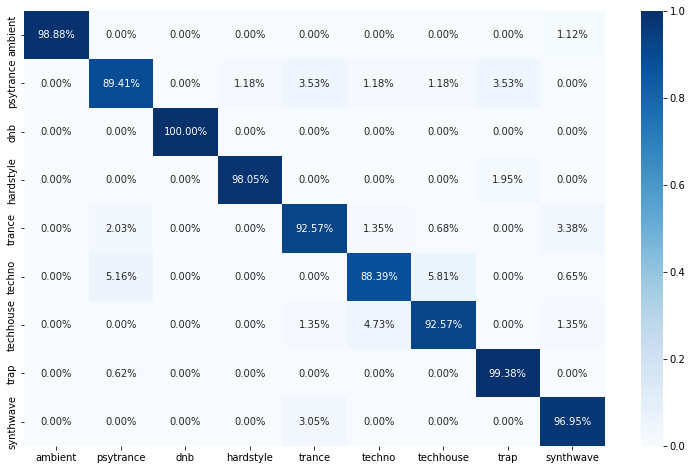

In [1137]:
# It has also solved the unbalancing of the classification in techno, trance and synthwave
# This will be the model we will use of our project

x_axis_labes = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
y_axis_labels = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
plt.figure(figsize=(13,8))
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true', labels=np.unique(y_test)), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=x_axis_labes, yticklabels=y_axis_labels);

In [1139]:
# # The code below will be used to save our model into the specific folder

# filename = 'my_model'
# date = str(datetime.today().strftime('%y%m%d%H%M%S'))
# name = filename + date
# path = '../../models/' + filename
# with open(path, 'wb') as archivo_salida:
#     pickle.dump(rf, archivo_salida)